In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

--2023-04-06 10:39:43--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M   196MB/s    in 1.5s    

2023-04-06 10:39:44 (196 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]



In [ ]:
!tar xf spark-3.3.2-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.2-bin-hadoop3'

In [ ]:
# Install library for finding Spark
!pip install -q findspark


In [ ]:
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

'/content/spark-3.3.2-bin-hadoop3'

In [ ]:
# Import SparkSession
from pyspark.sql import SparkSession


In [ ]:
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()# Check Spark Session Information


In [ ]:
spark

In [ ]:
# Import a Spark function from library
from pyspark.sql.functions import col

In [ ]:
import gdown

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1v4OD0yJXQABjA9ZTfllpE9u4dPq0BOzf/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1v4OD0yJXQABjA9ZTfllpE9u4dPq0BOzf
To: /content/master.csv
100% 2.71M/2.71M [00:00<00:00, 204MB/s]


In [ ]:
# Print the schema of the DataFrame
suicide_df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)
 |-- suicides_no: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- gdp_per_capita ($): integer (nullable = true)



In [ ]:
# Convert columns to their appropriate data types
suicide_df = suicide_df.withColumn("year", col("year").cast("integer"))
suicide_df = suicide_df.withColumn("suicides_no", col("suicides_no").cast("integer"))
suicide_df = suicide_df.withColumn("population", col("population").cast("integer"))
suicide_df = suicide_df.withColumn("gdp_per_capita ($)", col("gdp_per_capita ($)").cast("integer"))


In [ ]:
# Show basic statistics of the numerical columns
suicide_df.select("suicides_no", "population", "gdp_per_capita ($)").describe().show()


+-------+------------------+------------------+------------------+
|summary|       suicides_no|        population|gdp_per_capita ($)|
+-------+------------------+------------------+------------------+
|  count|             27820|             27820|             27820|
|   mean|242.57440690150972|1844793.6173975556|16866.464414090584|
| stddev| 902.0479168336403|3911779.4417563565|18887.576472205576|
|    min|                 0|               278|               251|
|    max|             22338|          43805214|            126352|
+-------+------------------+------------------+------------------+



root
 |-- country: string (nullable = true)
 |-- year: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: string (nullable = true)
 |-- population: string (nullable = true)
 |-- suicides/100k pop: string (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: string (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita ($): string (nullable = true)
 |-- generation: string (nullable = true)



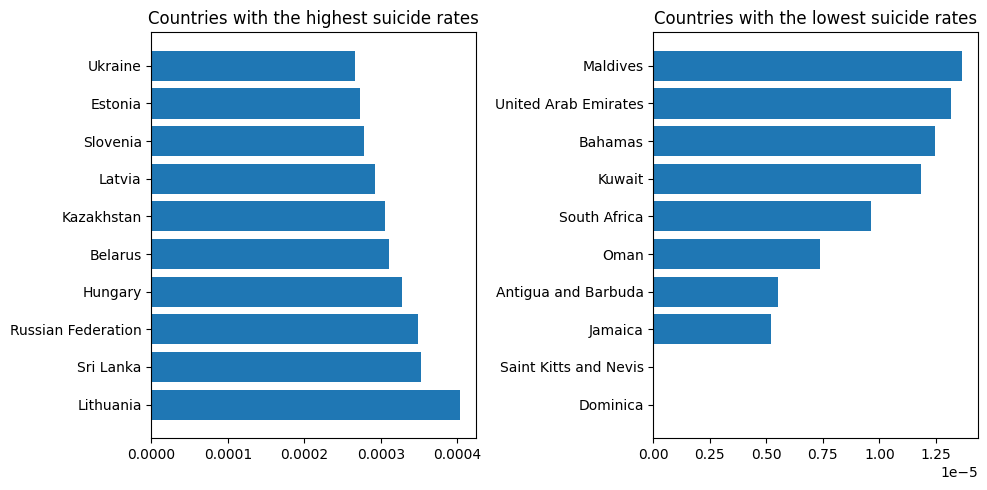

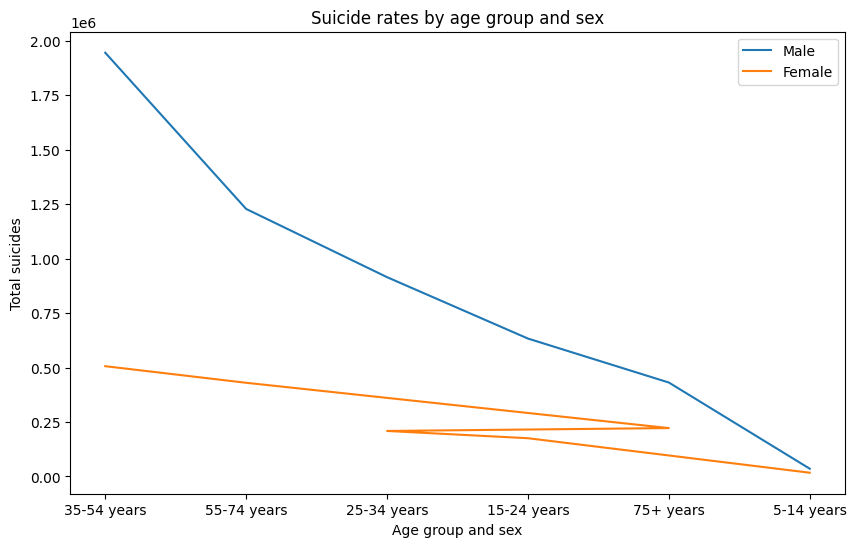

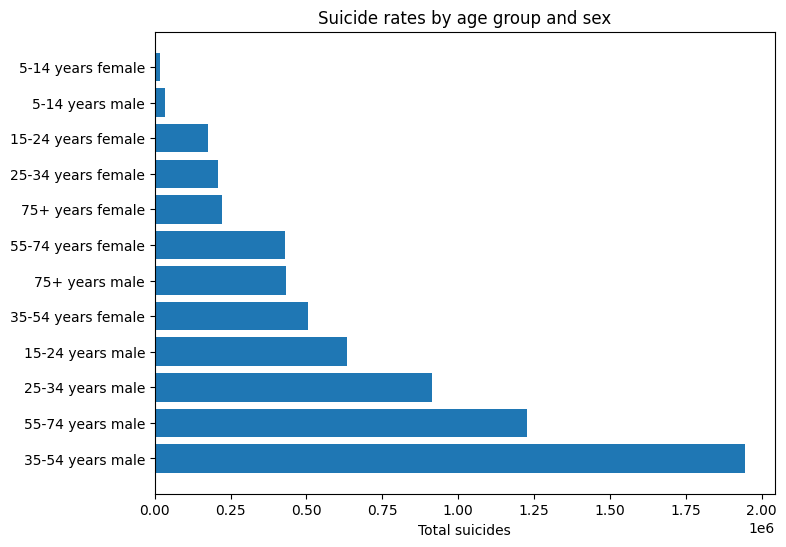

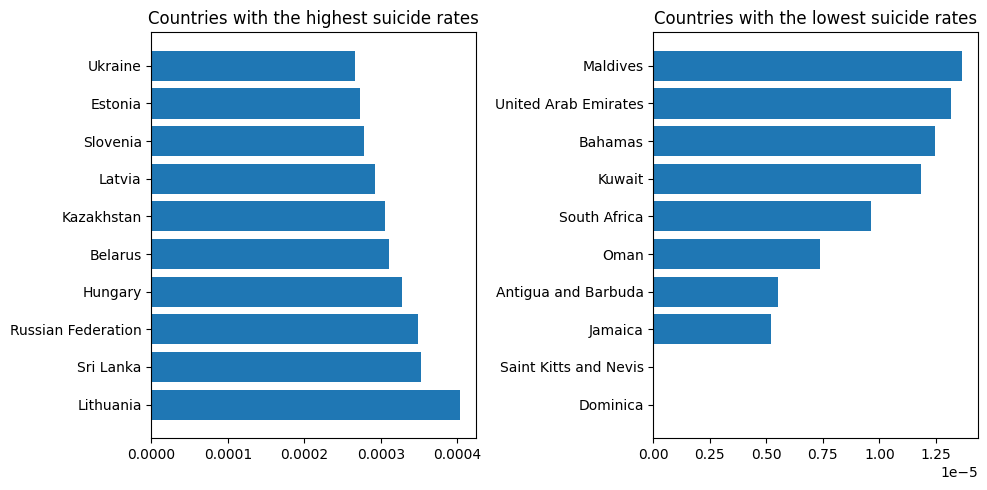

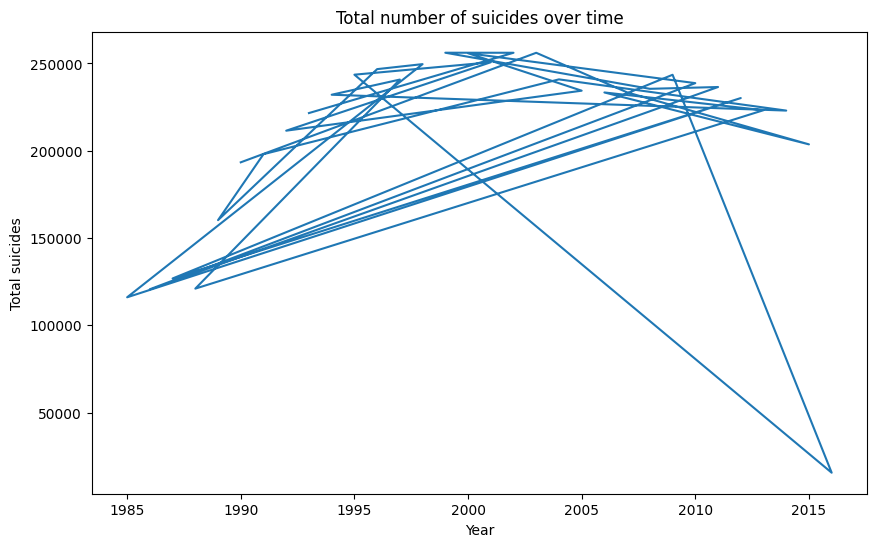

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum
import matplotlib.pyplot as plt

# Create a SparkSession
spark = SparkSession.builder.appName("SuicideAnalysis").getOrCreate()

# Load the dataset into a DataFrame
suicide_df = spark.read.format("csv").option("header", "true").load("master.csv")

# Print the schema of the DataFrame
suicide_df.printSchema()

# Filter out unnecessary columns
suicide_df = suicide_df.select("year", "age", "sex", "country", "suicides_no", "population", "gdp_per_capita ($)")

# Convert columns to their appropriate data types
suicide_df = suicide_df.withColumn("year", col("year").cast("integer"))
suicide_df = suicide_df.withColumn("suicides_no", col("suicides_no").cast("integer"))
suicide_df = suicide_df.withColumn("population", col("population").cast("integer"))
suicide_df = suicide_df.withColumn("gdp_per_capita ($)", col("gdp_per_capita ($)").cast("integer"))

# Calculate the average suicide rate by country and year
avg_suicide_rate = suicide_df.groupBy("country", "year").agg(avg(col("suicides_no")/col("population")).alias("avg_suicide_rate"))

# Calculate the total number of suicides by country and year
total_suicides = suicide_df.groupBy("country", "year").agg(sum(col("suicides_no")).alias("total_suicides"))

# Join the two DataFrames
suicide_analysis = avg_suicide_rate.join(total_suicides, ["country", "year"])

# Calculate the countries with the highest and lowest suicide rates
highest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").desc()).limit(10)
lowest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").asc()).limit(10)

# Convert the DataFrames to Pandas for visualization
highest_suicide_rates_pd = highest_suicide_rates.toPandas()
lowest_suicide_rates_pd = lowest_suicide_rates.toPandas()

# Visualize the countries with the highest and lowest suicide rates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].barh(highest_suicide_rates_pd["country"], highest_suicide_rates_pd["avg_suicide_rate"])
ax[0].set_title("Countries with the highest suicide rates")
ax[1].barh(lowest_suicide_rates_pd["country"], lowest_suicide_rates_pd["avg_suicide_rate"])
ax[1].set_title("Countries with the lowest suicide rates")
plt.tight_layout()
plt.show()

# Calculate the suicide rates by age group and sex
suicide_by_age_sex = suicide_df.groupBy("age", "sex").agg(sum("suicides_no").alias("total_suicides")).orderBy(col("total_suicides").desc())

# Convert the DataFrame to Pandas for visualization
suicide_by_age_sex_pd = suicide_by_age_sex.toPandas()

# Calculate the suicide rates by age group and sex
suicide_by_age_sex = suicide_df.groupBy("age", "sex").agg(sum("suicides_no").alias("total_suicides")).orderBy(col("total_suicides").desc())

# Convert the DataFrame to Pandas for visualization
suicide_by_age_sex_pd = suicide_by_age_sex.toPandas()

# Visualize the suicide rates by age group and sex
plt.figure(figsize=(10, 6))
plt.plot(suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="male"]["age"], suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="male"]["total_suicides"], label="Male")
plt.plot(suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="female"]["age"], suicide_by_age_sex_pd[suicide_by_age_sex_pd["sex"]=="female"]["total_suicides"], label="Female")
plt.title("Suicide rates by age group and sex")
plt.xlabel("Age group and sex")
plt.ylabel("Total suicides")
plt.legend()
plt.show()


#Calculate the suicide rates by age group and sex
suicide_by_age_sex = suicide_df.groupBy("age", "sex").agg(sum("suicides_no").alias("total_suicides")).orderBy(col("total_suicides").desc())

#Convert the DataFrame to Pandas for visualization
suicide_by_age_sex_pd = suicide_by_age_sex.toPandas()

#Visualize the suicide rates by age group and sex
plt.figure(figsize=(8, 6))
plt.barh(suicide_by_age_sex_pd["age"] + " " + suicide_by_age_sex_pd["sex"], suicide_by_age_sex_pd["total_suicides"])
plt.title("Suicide rates by age group and sex")
plt.xlabel("Total suicides")
plt.show()

#Calculate the countries with the highest and lowest suicide rates
highest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").desc()).limit(10)
lowest_suicide_rates = suicide_analysis.groupBy("country").agg(avg(col("avg_suicide_rate")).alias("avg_suicide_rate")).orderBy(col("avg_suicide_rate").asc()).limit(10)

#Convert the DataFrames to Pandas for visualization
highest_suicide_rates_pd = highest_suicide_rates.toPandas()
lowest_suicide_rates_pd = lowest_suicide_rates.toPandas()

#Visualize the countries with the highest and lowest suicide rates
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].barh(highest_suicide_rates_pd["country"], highest_suicide_rates_pd["avg_suicide_rate"])
ax[0].set_title("Countries with the highest suicide rates")
ax[1].barh(lowest_suicide_rates_pd["country"], lowest_suicide_rates_pd["avg_suicide_rate"])
ax[1].set_title("Countries with the lowest suicide rates")
plt.tight_layout()
plt.show()

#Calculate the total number of suicides over time
suicides_over_time = suicide_df.groupBy("year").agg(sum(col("suicides_no")).alias("total_suicides"))

#Convert the DataFrame to Pandas for visualization
suicides_over_time_pd = suicides_over_time.toPandas()

#Visualize the total number of suicides over time
plt.figure(figsize=(10, 6))
plt.plot(suicides_over_time_pd["year"], suicides_over_time_pd["total_suicides"])
plt.title("Total number of suicides over time")
plt.xlabel("Year")
plt.ylabel("Total suicides")
plt.show()
